In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define Constants

In [2]:
MARKET_MEAN_PRICE = 100
UPPER_CHANGE = 0.25
LOWER_CHANGE = -0.25
"""
-> (a - b) / b = change
-> a - b = b * change
-> a = b * (change + 1)
"""
UPPER_BOUND = MARKET_MEAN_PRICE * (UPPER_CHANGE + 1)
LOWER_BOUND = MARKET_MEAN_PRICE * (LOWER_CHANGE + 1)
POSSIBLE_ACTIONS = (0., 0.25, 0.5, 0.75, 1.)

# Define Rewards

In [3]:
def mean_price_relative_reward(
    action: np.ndarray,
    market_mean_price: float,
    next_price: float,
    reward_scaling: float
) -> float:
    price_advantage = (1 - next_price / market_mean_price)
    reward = reward_scaling * action * price_advantage

    return reward


def action_magnitude_reward(action: float, reward_scaling: float) -> float:
    reward = action ** 2
    reward = -reward * reward_scaling

    return reward

# Visualize Mean Price Relative Rewards

In [4]:
def get_mean_price_relative_rewards(action: float, reward_scaling: float):
    assert 0. <= action <= 1.
    
    prices_range = np.arange(LOWER_BOUND, UPPER_BOUND + 1)
    mean_price_relative_rewards = []
    for price in prices_range:
        mean_price_relative_rewards.append(
            mean_price_relative_reward(
                action=action,
                market_mean_price=MARKET_MEAN_PRICE,
                next_price=price,
                reward_scaling=reward_scaling
            )
        )
        
    return prices_range, mean_price_relative_rewards


def plot_mean_price_relative_rewards_for(reward_scaling: float):
    for action in POSSIBLE_ACTIONS:
        prices_range, mean_price_relative_rewards = get_mean_price_relative_rewards(action, reward_scaling)
        prices_range = prices_range / MARKET_MEAN_PRICE
        plt.plot(prices_range, mean_price_relative_rewards, label=str(action))
    plt.legend()

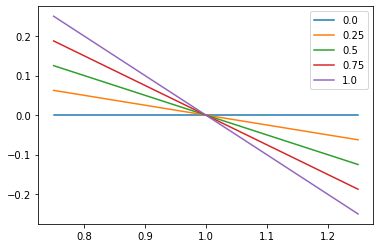

In [5]:
plot_mean_price_relative_rewards_for(reward_scaling=1)

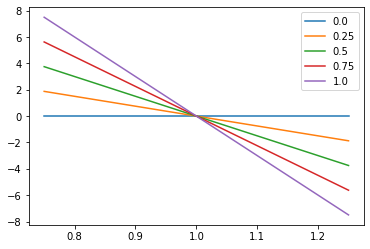

In [6]:
plot_mean_price_relative_rewards_for(reward_scaling=30)

# Visualize Action Magnitude Rewards

In [7]:
def plot_action_magnitude_rewards_for(reward_scaling: float):
    labels = []
    rewards = []
    for action in POSSIBLE_ACTIONS:
        labels.append(str(action))
        rewards.append(
            action_magnitude_reward(action, reward_scaling)
        )
    
    plt.bar(labels, rewards)

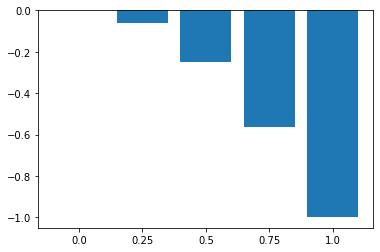

In [8]:
plot_action_magnitude_rewards_for(reward_scaling=1.)

# Visualize Together

In [9]:
def plot_aggregated(reward_scaling_price: float, reward_scaling_action: float, global_normalization: float = 1., actions=POSSIBLE_ACTIONS):
    max_reward = -9999999
    for action in actions:
        prices_range, mean_price_relative_rewards = get_mean_price_relative_rewards(action, reward_scaling_price)
        action_reward = action_magnitude_reward(action, reward_scaling_action)
        rewards = np.array(mean_price_relative_rewards) + action_reward
        rewards *= global_normalization
        
        if rewards.max() > max_reward:
            max_reward = rewards.max()
        
        plt.plot(prices_range / MARKET_MEAN_PRICE, rewards, label=str(action))
    
    max_reward = int(max_reward) + 1
    x_data = prices_range / MARKET_MEAN_PRICE
    median_item_index = np.argsort(x_data)[len(x_data)//2]

    plt.vlines(x=x_data[median_item_index-int(0.4*median_item_index)], ymin=-max_reward, ymax=max_reward, color='k', linestyles='--', linewidth=0.5)
    plt.vlines(x=x_data[median_item_index], ymin=-max_reward, ymax=max_reward, color='k', linestyles='--', linewidth=0.5)
    plt.vlines(x=x_data[median_item_index+int(0.4*median_item_index)], ymin=-max_reward, ymax=max_reward, color='k', linestyles='--', linewidth=0.5)
    
    for y in range(1, int(max_reward) + 1):
        plt.hlines(y=y, xmin=x_data.min(), xmax=x_data.max(), color='k', linestyle='--', linewidth=0.5)
        plt.hlines(y=-y, xmin=x_data.min(), xmax=x_data.max(), color='k', linestyle='--', linewidth=0.5)
        
    plt.legend()

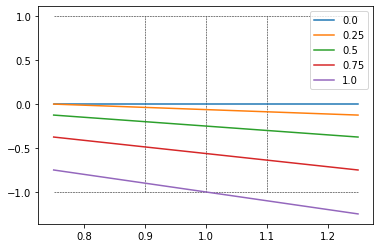

In [10]:
# We can see that if the rewards are not scaled the agent will never get positive rewards.
plot_aggregated(reward_scaling_price=1., reward_scaling_action=1.)

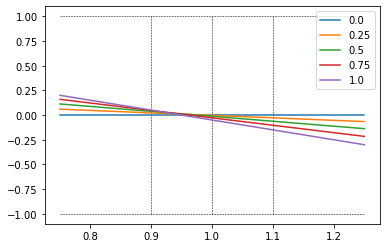

In [11]:
# Also it is not enough to scale only the reward_scaling_action because of the following reasons:
# - if you scale it too much down it because redundant
# - the rewards in this setup are too small to propagate any useful information
# - it is very hard for the agent to get any positive reinforcement
plot_aggregated(reward_scaling_price=1., reward_scaling_action=0.05)

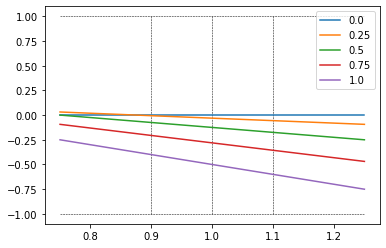

In [12]:
# This was the setup used until now. We can see now why the agent was only taking the actions: '0.0' and '0.25'.
# Those actions were the only ones with a shred of hope.
plot_aggregated(reward_scaling_price=1., reward_scaling_action=0.5)

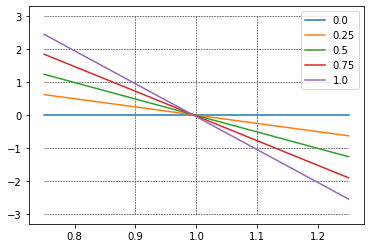

In [13]:
# We can see that if we start to scale the price reward the values start to grow & 
# the graph start to be more symmetrical. Which gives the agent the change to have +- reinforcements.
plot_aggregated(reward_scaling_price=10., reward_scaling_action=0.05)

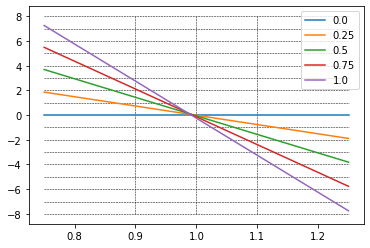

In [14]:
# This seems to be a symmetric reward between positive & negative ones.
plot_aggregated(reward_scaling_price=30., reward_scaling_action=0.25)
# Even the magnitude of the rewards seem ok. Usually there is no more than +-10% volatility within a month.

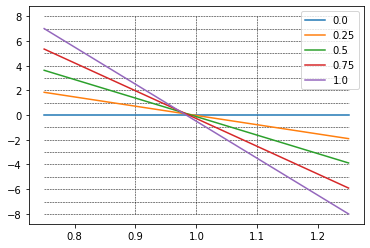

In [15]:
# Let's look for a setup where the agent is reinforcent slightly negative
# if it takes a big action at the wrong time.
plot_aggregated(reward_scaling_price=30, reward_scaling_action=0.5)

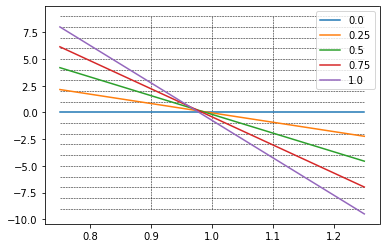

In [16]:
plot_aggregated(reward_scaling_price=35, reward_scaling_action=0.75)

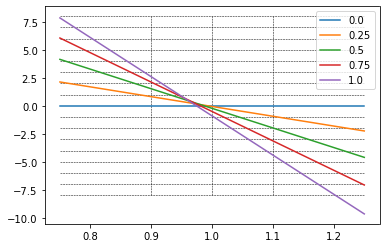

In [17]:
# This setup looks nice because the agent for a conservative action of '0.25' will have a +-1 reward for a price
# movement of +-10%. Also it is slitgly shifted to the negative zone to still force the agent to take only the best actions. 
plot_aggregated(reward_scaling_price=35, reward_scaling_action=0.9)

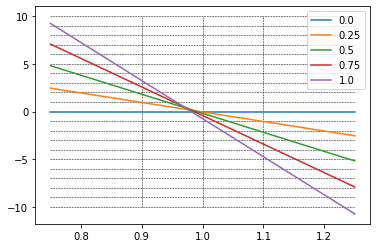

In [31]:
# Let's look for a slightly more generous setup.
plot_aggregated(reward_scaling_price=40, reward_scaling_action=0.75)

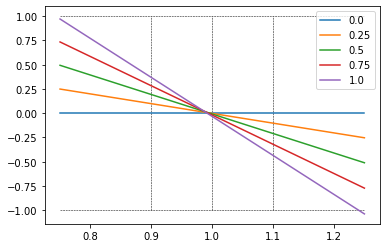

In [18]:
# Now let's try to squeeze the values into a more decent interval
# 1 / 7.5 ~= 0.134
plot_aggregated(reward_scaling_price=30, reward_scaling_action=0.25, global_normalization=0.134)
# Now we have all the values squeezed between ~[-1, +1]

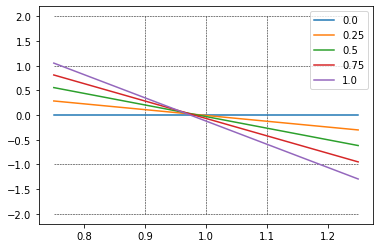

In [19]:
plot_aggregated(reward_scaling_price=35, reward_scaling_action=0.9, global_normalization=0.134)

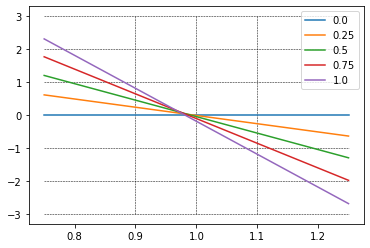

In [32]:
# This looks nice. Because for an action of "1." the agent will take a reward of +-1 for a +-10% change
plot_aggregated(reward_scaling_price=40, reward_scaling_action=0.75, global_normalization=0.25)

# More Actions

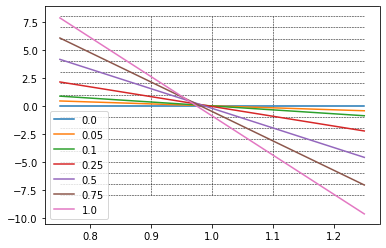

In [21]:
plot_aggregated(reward_scaling_price=35, reward_scaling_action=0.9, actions=(0., 0.05, 0.1, 0.25, 0.5, 0.75, 1.))

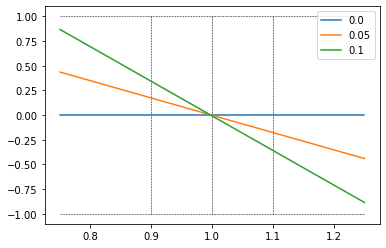

In [22]:
# We can see that if the actions are too small than the magnitude action reward does not have any effect.
plot_aggregated(reward_scaling_price=35, reward_scaling_action=0.9, actions=(0., 0.05, 0.1))

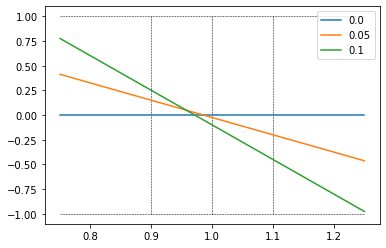

In [23]:
# Even if we scale up by a lot the reward_scaling_action it barely starts to move.
plot_aggregated(reward_scaling_price=35, reward_scaling_action=10, actions=(0., 0.05, 0.1))

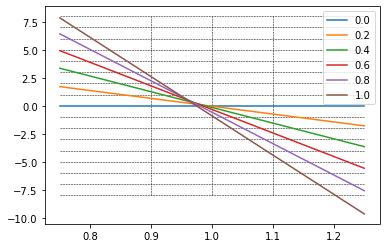

In [24]:
# In this way the action rewards look more evenly distributed & with a good magnitude.
# Also the agent has another action to choose from.
plot_aggregated(reward_scaling_price=35, reward_scaling_action=0.9, actions=(0., 0.2, 0.4, 0.6, 0.8, 1.))

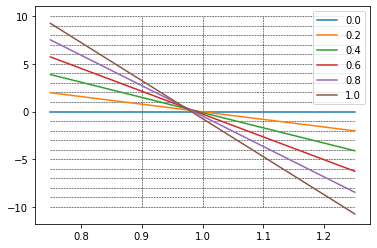

In [33]:
plot_aggregated(reward_scaling_price=40, reward_scaling_action=0.75, actions=(0., 0.2, 0.4, 0.6, 0.8, 1.))

# Define Action Distance Rewards

In [113]:
ACTIONS = np.array([
    [0.25, 0.25, 0.25, 0.25, 0, 0, 0., 0, 0, 0, 0, 0, 0, 0, 0, 0., 0, 0, 0, 0, 0., 0, 0],
    [0.5, 0, 0, 0, 0, 0, 0., 0, 0, 0, 0, 0, 0, 0, 0, 0., 0, 0, 0, 0, 0., 0, 0.5],
    [0., 0, 0, 0, 0, 0, 0., 0, 0, 0, 0, 0, 0, 0, 0, 0., 0, 0, 0, 0, 0., 0, 1.],
    [0.25, 0, 0, 0, 0, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0.25, 0, 0, 0, 0, 0.25, 0, 0],
    ],
    dtype=np.float32
)
MAX_DISTANCE = ACTIONS.shape[1]

In [148]:
def action_distance_reward_func(actions, reward_scaling: float):
    if actions.shape[0] == 0 or actions[-1] == 0.:
        return 0.
    
    max_distance = len(actions)
    action_indices = np.where(actions != 0)[0]
    num_actions = action_indices.shape[0]
    if num_actions <= 1:
        return 0.
    
    # Compute the absolute mean difference between an action and every action before it.
    action_indices = np.tile(action_indices, reps=(num_actions, 1))
    diag_action_indices = np.expand_dims(np.diag(action_indices), axis=1)
    difference = action_indices - diag_action_indices
    difference = np.tril(difference)
    difference = difference[difference != 0]
    difference += 1
    difference = np.abs(difference)
    difference = np.mean(difference)

    reward = difference / (MAX_DISTANCE + 1)
    reward *= reward_scaling

    return reward.item()


def cash_on_last_tick_reward_func(cash_used: float, reward_scaling: float = 1., max_value: float = 5000.):
    reward = cash_used / max_value
    reward *= reward_scaling
    
    return -reward


def roll(actions, reward_scaling: float):
    rewards = []
    for i in range(len(actions) + 1):
        rewards.append(
            action_distance_reward_func(actions[:i], reward_scaling)
        )
        
    return np.array(rewards)


def plot_roll(actions, reward_scaling: float, ax, rewards_offset: float):
    rewards = roll(actions, reward_scaling)
    if actions[-1] != 0:
        print(rewards[-1])
        rewards[-1] += rewards_offset
    
    ax.bar(range(len(actions) + 1), rewards)
    
    
def plot_reward_funcs(actions):
    print(f'ACTIONS: {actions}')
    
    if actions[-1] != 0:
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
        for i, cash_used in enumerate([1250, 2500, 3725, 5000]):
            current_ax = ax.ravel()[i]
            current_ax.set_title(f'Cash used on last tick: {cash_used}')

            cash_on_last_tick_reward = cash_on_last_tick_reward_func(cash_used, reward_scaling=1.)
            plot_roll(actions, 0.5, current_ax, cash_on_last_tick_reward)
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
        plot_roll(actions, 0.5, ax, 0)
        


ACTIONS: [0.25 0.25 0.25 0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]


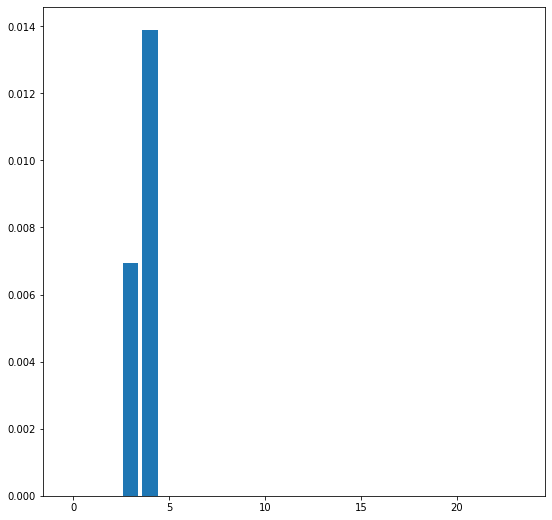

In [149]:
plot_reward_funcs(ACTIONS[0])

ACTIONS: [0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.5]
0.4375
0.4375
0.4375
0.4375


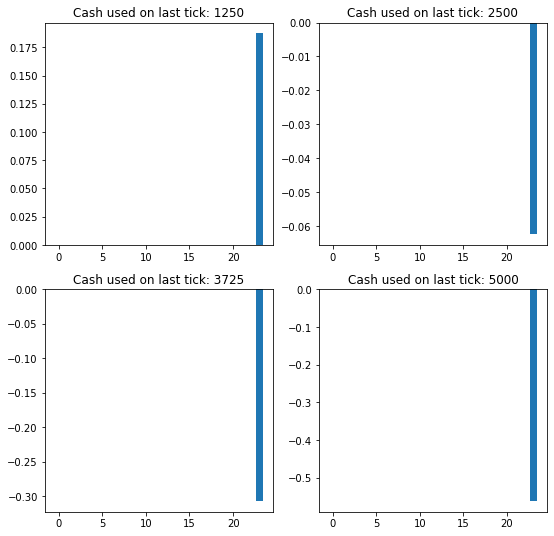

In [150]:
plot_reward_funcs(ACTIONS[1])

ACTIONS: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
0.0
0.0
0.0
0.0


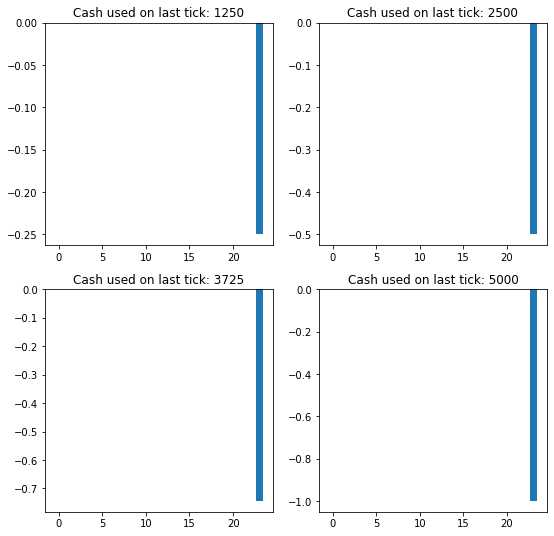

In [151]:
plot_reward_funcs(ACTIONS[2])

ACTIONS: [0.25 0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.   0.
 0.   0.25 0.   0.   0.   0.   0.25 0.   0.  ]


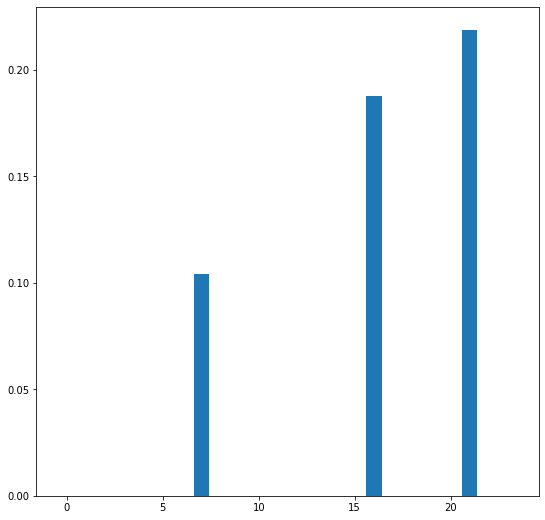

In [152]:
plot_reward_funcs(ACTIONS[3])

It looks like a `reward_scaling=0.5` for the action distance functions & a `reward_scaling=1.` for the cash used on the last thick look like a good & complementary start